# Project part 2: beat flappy bird

You may be familiar with the game [flappy bird](https://flappybird.io/). It is very simple: a bird moves at constant speed on the x axis and, to direct him, you can either push it up or let it fall at each step. The goal of the game is to go as far as possible.

Your goal for this project is as follow: design and train an agent which does the best possible score at flappy bird !

## The environment

We will use the Flappy Bird environment defined in the deep_rl package. Let's have a closer look at it.


In [13]:
import copy
import pickle
import time
from time import time
from typing import List, Tuple

import chex
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
from IPython.display import clear_output
from tqdm import trange

from deep_rl.environments.flappy_bird import FlappyBird
from deep_rl.episode_runner import run_episode
from deep_rl.terminal_renderer import BashRenderer
from helper import (
    compute_features_from_observation,
    get_value_action,
    plot_observation,
    plot_value_action,
    save_best_model,
)

# for reloading modules in notebook
%load_ext autoreload
%autoreload 2

In [2]:
env = FlappyBird(
    gravity=0.05,
    force_push=0.1,
    vx=0.05,
    prob_new_bar=1,
    invictus_mode=False,
    max_height_bar=0.5,
)

print(env.help)



    Welcome to our custom flappy bird game !

    A bird moves at a constant horizontal speed while gravity governs the vertical axis.
    The goal is to make the bird avoid obstacles on the screen for as long as possible.

    At each step. two actions are available:
        0: do nothing and let it fall.
        1: push the bird upward

    Observations have the following shape:
        BIRD_COORDINATES, [BAR_0, BAR_1, ..., BAR_N]

    Where:
        BIRD_COORDINATES = (X_BIRD, Y_BIRD, V_Y_BIRD)
        WIth:
            - X_BIRD: the position of the bird on the x-axis
            - Y_BIRD: the position of the bird on the y-axis
            - V_Y_BIRD: the velocity of the bird along the y-axis

        BAR_0, BAR_1, ... , BAR_N are the coordinates of the bars visibles in the 
        environment.

        With BAR_i = (X_LEFT, X_RIGHT, HEIGHT, POSITION)
        Where BAR_i is a rectangle with:
            X_LEFT: is the position of the left border of the bar
            X_RIGHT: is 

For example let's interact with it a little bit.

In [3]:
rows, cols = env.min_res
print(
    f"We should use at least {rows} rows and {cols} cols when rendering the environment"
)

obs_reset = env.reset()
print("First observation when reseting the environment:")
print(obs_reset)
print()

print("Now, let's perform a few steps\n")

print("Step 1: we let the bird fall")
obs, reward, done = env.step(0)
print(f"Observation: {obs}")
print(f"Reward: {reward}")
print(f"Game over: {done}")
print()

print("Step 2: we push the bird up")
obs, reward, done = env.step(1)
print(f"Observation: {obs}")
print(f"Reward: {reward}")
print(f"Game over: {done}")
print()

print("Step 3: we push the bird up again")
obs, reward, done = env.step(1)
print(f"Observation: {obs}")
print(f"Reward: {reward}")
print(f"Game over: {done}")
print()

print("Step 4: we push the bird up again")
obs, reward, done = env.step(1)
print(f"Observation: {obs}")
print(f"Reward: {reward}")
print(f"Game over: {done}")
print()


We should use at least 20 rows and 20 cols when rendering the environment
First observation when reseting the environment:
((0.5, 0.5, 0.0), [])

Now, let's perform a few steps

Step 1: we let the bird fall
Observation: ((0.5, 0.45, -0.05), [(1.0, 1.1, 0.39310783277998373, False)])
Reward: 0
Game over: False

Step 2: we push the bird up
Observation: ((0.5, 0.45, 0.0), [(1.0, 1.1, 0.3024255072161014, True), (0.95, 1.05, 0.39310783277998373, False)])
Reward: 0
Game over: False

Step 3: we push the bird up again
Observation: ((0.5, 0.5, 0.05), [(0.95, 1.05, 0.3024255072161014, True), (0.8999999999999999, 0.9999999999999999, 0.39310783277998373, False)])
Reward: 0
Game over: False

Step 4: we push the bird up again
Observation: ((0.5, 0.6, 0.1), [(0.8499999999999999, 0.9499999999999998, 0.39310783277998373, False), (0.8999999999999999, 0.9999999999999999, 0.3024255072161014, True)])
Reward: 0
Game over: False



To simplify typing a bit, the deep_rl package implements a new type `FlappyObs` which corresponds to a state of the flappy bird environment.

In [9]:
BarObs = Tuple[float, float, float, bool]
BirdObs = Tuple[float, float, float]
FlappyObs = Tuple[BirdObs, List[BarObs]]


## Baseline

We provide you with a simple baseline: the `StableAgent` which does nothing more than keeping the bird stable.

In [10]:
class StableAgent:
    """An agent which just keeps the bird stable."""

    def __init__(self, target_y: float = 0.5):
        self._target_y = target_y

    def sample_action(
        self,
        observation: FlappyObs,
        evaluation: bool,
    ) -> int:
        _, y_bird, v_y_bird = observation[0]

        if y_bird <= self._target_y and v_y_bird <= 0:
            return 1
        else:
            return 0


Let's see how a single runs works in practice with this agent.

In [11]:
# We are going to render the environment !
ROWS = 30
COLS = 60
# Because ipython sucks, I have not found a cleaner option to add
# the refresher function
renderer = BashRenderer(ROWS, COLS, clear_fn=lambda: clear_output(wait=True))

# Flappy bird environment
env = FlappyBird(
    gravity=0.05,
    force_push=0.1,
    vx=0.05,
    prob_new_bar=0.3,
    max_height_bar=0.6,
)

# Our agent
agent = StableAgent()

# We run a single episode, with rendering, over a maximum of 100 steps
run_episode(env, agent, max_steps=2, renderer=renderer, time_between_frame=1)


　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🐤　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　

0

We define a hard observation, that will be used to plot the value function during the training


(<Figure size 800x400 with 1 Axes>, <Axes: >)

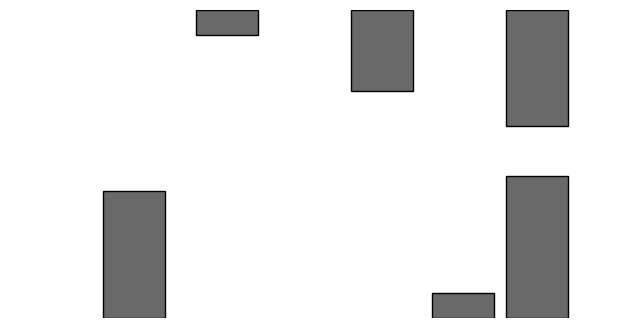

In [14]:
observation = (
    (0.5, 0.5, 0.0),
    [
        (0.1499999999999997, 0.2499999999999997, 0.4123647820706887, True),
        (0.7999999999999998, 0.8999999999999998, 0.37547680672428224, False),
        (0.5499999999999996, 0.6499999999999996, 0.2644069551051657, False),
        (0.29999999999999966, 0.3999999999999997, 0.08111256304703442, False),
        (0.7999999999999998, 0.8999999999999998, 0.4623647820706887, True),
        (0.68, 0.78, 0.08111256304703442, True),
    ],
)

print("We define a hard observation, that will be used to plot the value function during the training")
plot_observation(observation)


In [15]:
@chex.dataclass
class Transition:
    state_t: chex.Array
    action_t: chex.Array
    reward_t: chex.Array
    done_t: chex.Array
    state_tp1: chex.Array


class ReplayBuffer:
    """Fixed-size buffer to store transition tuples."""

    def __init__(self, buffer_capacity: int):
        """Initialize a ReplayBuffer object.
        Args:
            buffer_capacity (int): maximal number of tuples to store at once
        """
        self._memory = list()
        self._maxlen = buffer_capacity

    @property
    def size(self) -> int:
        # Return the current number of elements in the buffer.
        return len(self._memory)

    def add(
        self,
        state_t: chex.Array,
        action_t: chex.Array,
        reward_t: chex.Array,
        done_t: chex.Array,
        state_tp1: chex.Array,
    ) -> None:
        """Add a new transition to memory."""

        if self.size > self._maxlen:
            self._memory = self._memory[1:]

        self._memory.append(
            Transition(
                state_t=state_t,
                action_t=action_t,
                reward_t=reward_t,
                done_t=done_t,
                state_tp1=state_tp1,
            )
        )

    def sample(self) -> Transition:
        """Randomly sample a transition from memory."""
        assert self._memory, "replay buffer is unfilled"
        # Your code here !
        index = np.random.randint(self.size)
        return self._memory[index]


class BatchedReplayBuffer(ReplayBuffer):
    def sample_batch(self, batch_size) -> Transition:
        """Randomly sample a batch of experiences from memory."""
        assert (
            len(self._memory) >= batch_size
        ), "Insuficient number of transitions in replay buffer"
        # Your code here !
        samples = [self.sample() for i in range(batch_size)]
        kwargs = dict()
        for attr in ["action_t", "reward_t", "done_t"]:
            kwargs[attr] = np.array([getattr(s, attr) for s in samples])
        for attr in ["state_t", "state_tp1"]:
            kwargs[attr] = np.array(
                [compute_features_from_observation(getattr(s, attr)) for s in samples]
            )
        return Transition(**kwargs)


In [16]:
def network(x: chex.Array, n_actions: int) -> chex.Array:
    out = hk.nets.MLP([32, n_actions], activation=jax.nn.relu)(x)
    return out


In [17]:
# @title **[Implement]** Define your agent

# A convenient way to pack together all the variables we need when updating
# the agent.
@chex.dataclass
class LearnerState:
    online_params: hk.Params
    target_params: hk.Params
    opt_state: optax.OptState


class DeepAgent:
    def __init__(
        self,
        env,
        gamma: float,
        eps: float,
        learning_rate: float,
        buffer_capacity: int,
        min_buffer_capacity: int,
        batch_size: int,
        target_ema: float,
        seed: int = 0,
    ) -> None:
        """Initializes the DQN agent.

        Args:
          env: input catch environment.
          gamma: discount factor
          eps: probability to perform a random exploration when picking a new action.
          learning_rate: learning rate of the online network
          buffer_capacity: capacity of the replay buffer
          min_buffer_capacity: min buffer size before picking batches from the
            replay buffer to update the online network
          batch_size: batch size when updating the online network
          target_ema: weight when updating the target network.
          seed: seed of the random generator.
        """
        self._env = env
        self._learning_rate = learning_rate
        self._eps = eps
        self._gamma = gamma
        self._batch_size = batch_size
        self._target_ema = target_ema
        self._Na = env.N_ACTIONS

        # track the visit of each state
        # The keys are the hashed states, the values are the number of times we visited it.
        self._visits = {}

        # Define the neural network for this agent
        self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_qfunction))
        # Jit the forward pass of the neural network for better performances
        self.apply = jax.jit(self._apply)

        # Also jit the update functiom
        self._update_fn = jax.jit(self._update_fn)

        # Initialize the network's parameters
        self._rng = jax.random.PRNGKey(seed)
        self._rng, init_rng = jax.random.split(self._rng)
        self._learner_state = self._init_state(init_rng)

        # Initialize the replay buffer
        self._min_buffer_capacity = min_buffer_capacity
        self._buffer = BatchedReplayBuffer(buffer_capacity)

        # Build a variable to store the last state observed by the agent
        self._state = None

    def _optimizer(self) -> optax.GradientTransformation:
        return optax.adam(learning_rate=self._learning_rate)

    def _hk_qfunction(self, state: chex.Array) -> chex.Array:
        return network(state, self._Na)

    def first_observe(self, state: chex.Array) -> None:
        self._state = state

    def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
        """Initialize the online parameters, the target parameters and the
        optimizer's state."""
        dummy_step = compute_features_from_observation(self._env.reset())[None]

        online_params = self._init(rng, dummy_step)
        target_params = online_params
        opt_state = self._optimizer().init(online_params)

        return LearnerState(
            online_params=online_params,
            target_params=target_params,
            opt_state=opt_state,
        )

    def act(
        self,
        state: chex.Array,
        evaluation: bool,
    ) -> chex.Array:
        """Picks the next action using an epsilon greedy policy.

        Args:
          state: observed state.
          eval: if True the agent is acting in evaluation mode (which means it only
            acts according to the best policy it knows.)
        """
        # Fill in this function to act using an epsilon-greedy policy.
        if not evaluation and np.random.uniform() < self._eps:
            return np.random.randint(self._Na)
        return np.argmax(self._apply(self._learner_state.online_params, state[None]))

    def loss_fn(
        self,
        online_params: hk.Params,
        target_params: hk.Params,
        state_t: chex.Array,
        action_t: chex.Array,
        reward_t: chex.Array,
        done_t: chex.Array,
        state_tp1: chex.Array,
    ) -> chex.Array:
        """Computes the Q-learning loss

        Args:
          online_params: parameters of the online network
          target_params: parameters of the target network
          state_t: batch of observations at time t
          action_t: batch of actions performed at time t
          reward_t: batch of rewards obtained at time t
          done_t: batch of end of episode status at time t
          state_tp1: batch of states at time t+1
        Returns:
          The Q-learning loss.
        """
        # Step one: compute the target Q-value for state t+1
        q_tp1 = self._apply(target_params, state_tp1)

        # We do not want to consider the Q-value of states that are done !
        # For theses states, q(t+1) = 0
        q_tp1 = (1.0 - done_t[..., None]) * q_tp1

        # Now deduce the value of the target cumulative reward
        y_t = reward_t + self._gamma * jnp.max(q_tp1, axis=1)  # Shape B

        # Compute the online Q-value for state t
        q_t = self._apply(online_params, state_t)  # Shape B , Na

        # Ok, but we only want the Q value for the actions that have actually
        # been played
        q_at = jax.vmap(lambda idx, q: q[idx])(action_t, q_t)

        # Compute the square error
        error = (q_at - y_t) ** 2

        # Deduce the loss
        return jnp.mean(error)

    def _update_fn(
        self,
        state: LearnerState,
        batch: Transition,
    ) -> Tuple[chex.Array, LearnerState]:
        """Get the next learner state given the current batch of transitions.

        Args:
          state: learner state before update.
          batch: batch of experiences (st, at, rt, done_t, stp1)
        Returns:
          loss, learner state after update
        """

        # Compute gradients
        loss, gradients = jax.value_and_grad(self.loss_fn)(
            state.online_params,
            state.target_params,
            batch.state_t,
            batch.action_t,
            batch.reward_t,
            batch.done_t,
            batch.state_tp1,
        )

        # Apply gradients
        updates, new_opt_state = self._optimizer().update(gradients, state.opt_state)
        new_online_params = optax.apply_updates(state.online_params, updates)

        # Update target network params as:
        # target_params <- ema * target_params + (1 - ema) * online_params
        new_target_params = jax.tree_map(
            lambda x, y: x + (1 - self._target_ema) * (y - x),
            state.target_params,
            new_online_params,
        )
        return loss, LearnerState(
            online_params=new_online_params,
            target_params=new_target_params,
            opt_state=new_opt_state,
        )

    def observe(
        self,
        action_t: chex.Array,
        reward_t: chex.Array,
        done_t: chex.Array,
        state_tp1: chex.Array,
    ) -> chex.Array:
        """Updates the agent from the given observations.

        Args:
          action_t: action performed at time t.
          reward_t: reward obtained after having performed action_t.
          done_t: whether or not the episode is over after performing action_t.
          state_tp1: state at which the environment is at time t+1.
        Returns:
          DQN loss obtained when updating the online network.
        """
        # First, we need to add the new transition to the memory buffer
        # Exploration bonus for Big Maze
        self._buffer.add(self._state, action_t, reward_t, done_t, state_tp1)
        self._state = state_tp1

        # We update the agent if and only if we have enought state stored in
        # memory.
        if self._buffer.size >= self._min_buffer_capacity:
            batch = self._buffer.sample_batch(self._batch_size)
            loss, self._learner_state = self._update_fn(self._learner_state, batch)
            return loss
        return 0.0

    def compute_q_value_from_observation(self, observation) -> chex.Array:
        """Compute the q value vector from a single observation

        Args:
            observation: observation (unpreprocessed) of the environment. May be obtained through `env.reset()`

        Returns:
            chex.Array: q vector of length the number of actions
        """
        features = compute_features_from_observation(observation)
        # q value: update if using other kind of agent
        q = self.apply(self._learner_state.online_params, features)
        return q


In [18]:
def run_dqn_episode(
    agent: DeepAgent,
    env,
    evaluation: bool,
    max_steps: int = 1000,
    renderer: bool = None,
    time_between_frame: float = 0.1,
) -> Tuple[float, int]:
    """Runs an agent on the environment `env`.

    Args:
        agent (DeepAgent): agent to run
        env (Maze): running environment
        evaluation (bool): eval mode. If `True`, the policy is greedy.
        max_steps (int, optional): Number of steps of the agent. Defaults to 1000.
        render (bool, optional): Real-time rendering of the policy run by the agent. Defaults to False.

    Returns:
        Tuple[float, int]:  final reward and  number of steps of the agent
    """
    state = copy.deepcopy(env.reset())
    agent.first_observe(state)
    n_steps = 0
    total_reward = 0

    # Run an episode.
    while True:
        # Generate an action from the agent's policy and step the environment.
        action = agent.act(compute_features_from_observation(state), evaluation)
        next_state, reward, done = env.step(action)
        if not evaluation:
            agent.observe(action, reward, done, copy.deepcopy(next_state))
        n_steps += 1
        total_reward += reward

        state = copy.deepcopy(next_state)
        if done or n_steps > max_steps:
            break

        if renderer is not None:
            renderer.clear()
            renderer.draw_list(env.render())
            renderer.draw_title(f"TOTAL REWARD : {total_reward}")
            renderer.render()
            time.sleep(time_between_frame)

    return total_reward, n_steps


In [19]:
def train_agent(
    agent: DeepAgent,
    env: FlappyBird,
    num_episodes: int = 2000,
    num_eval_episodes: int = 10,
    eval_every_N: int = 100,
    max_steps: int = 1000,
    verbose: int = 0,
) -> Tuple[List[int], List[float], List[int]]:
    """Trains an agent for a specified number of iterations

    Args:
        agent (DeepAgent): agent to run
        env (Maze): running environment
        num_episodes (int, optional): Number of episodes to run. Defaults to 2000.
        num_eval_episodes (int, optional): Number of validation episodes. Defaults to 10.
        eval_every_N (int, optional): Number of training episodes between a validation step. Defaults to 100.
        max_steps (int, optional): maximum number of steps per episode. Defaults to 1000.
        verbose (int, optional): Verbose level. Defaults to 0.
            * 0: display only the validation metrics
            * 1: display the training metrics
            * 2: plot the value function and the visited states
            * 3: 1 & 2

    Returns:
        Tuple[List[int], List[float], List[int]]: val episodes, val rewards and val number of steps of the agent
    """
    episodes = []
    eval_reward = 0
    eval_rewards = []
    eval_n_steps = []
    train_rewards = []
    train_n_steps = []
    starting_time = time()
    print(
        "{:^18}|{:^18}|{:^40}|{:^40}".format(
            "Episode number:",
            "Elapsed time (min)",
            f"Average reward on {num_eval_episodes} episodes",
            f"Average Steps on {num_eval_episodes} episodes",
        )
    )
    print(
        "------------------------------------------------------------------------------------------------------------------------"
    )
    display_pbar = verbose in [1, 3]
    display_plots = verbose in [2, 3]
    if display_pbar:
        pbar = trange(1, num_episodes + 1, desc="Training", leave=True)
    else:
        pbar = range(1, num_episodes + 1)

    for episode in pbar:
        # training step
        reward, n_step = run_dqn_episode(
            agent, env, evaluation=False, max_steps=max_steps
        )
        train_rewards.append(reward)
        train_n_steps.append(n_step)

        # training metrics, nothing interesting
        if display_pbar:
            pbar.set_postfix(
                {
                    f"Average last {eval_every_N} rewards": np.mean(
                        train_rewards[-100:]
                    ),
                    f"Average last {eval_every_N} n_steps": np.mean(
                        train_n_steps[-100:]
                    ),
                }
            )

        # evaluation 
        if episode % eval_every_N == 0:
            reward, n_step = np.mean(
                np.concatenate(
                    [
                        [
                            run_dqn_episode(
                                agent, env, evaluation=True, max_steps=max_steps
                            )
                        ]
                        for _ in range(num_eval_episodes)
                    ],
                    axis=0,
                ),
                axis=0,
            )
            print(
                "{:^18}|{:^18.2f}|{:^40}|{:^40}".format(
                    episode, (time() - starting_time) / 60, reward, n_step
                )
            )
            eval_rewards.append(reward)
            eval_n_steps.append(n_step)
            episodes.append(episode)
            
            save_best_model(agent, eval_rewards[-1], eval_reward, filename="best_model.pkl")
            # display value and action maps
            if display_plots:
                fig, axs = plot_value_action(agent, observation)
                plt.show()

    return episodes, eval_rewards, eval_n_steps


 Episode number:  |   Elapsed time   |     Average reward on 10 episodes      |      Average Steps on 10 episodes      
------------------------------------------------------------------------------------------------------------------------
       100        |       0.65       |                  6.5                   |                  52.3                  
Saving best model at best_model.pkl


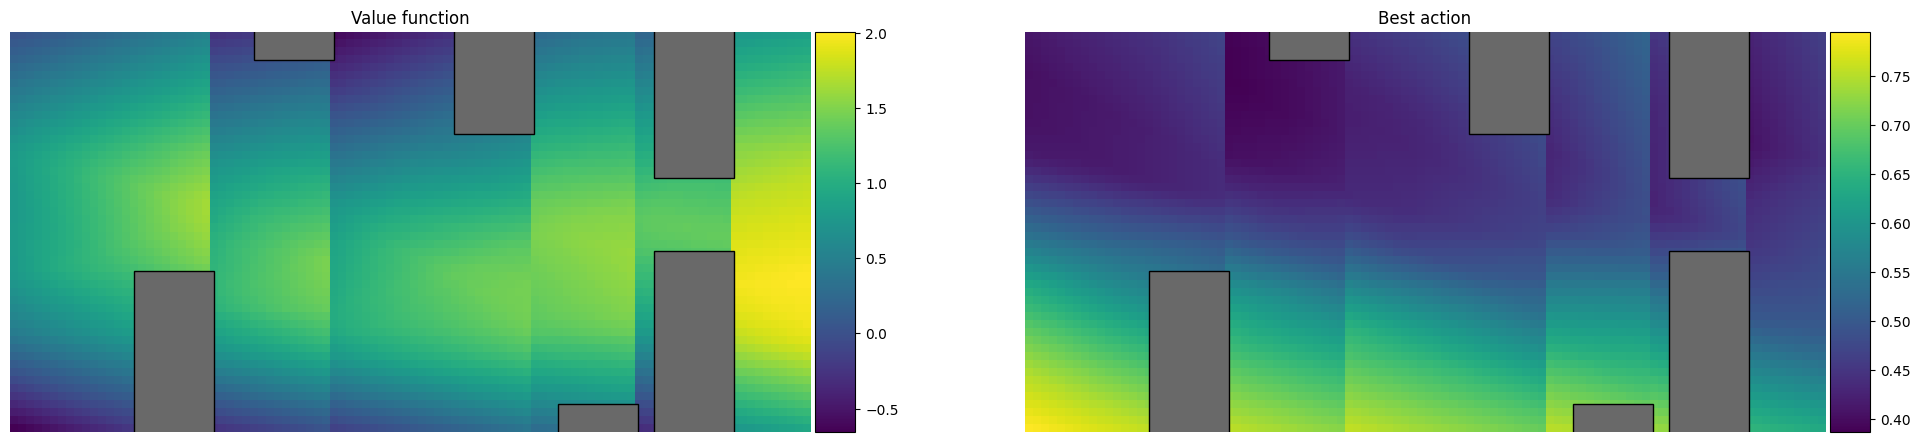

       200        |       2.11       |                  28.1                  |                 148.6                  
Saving best model at best_model.pkl


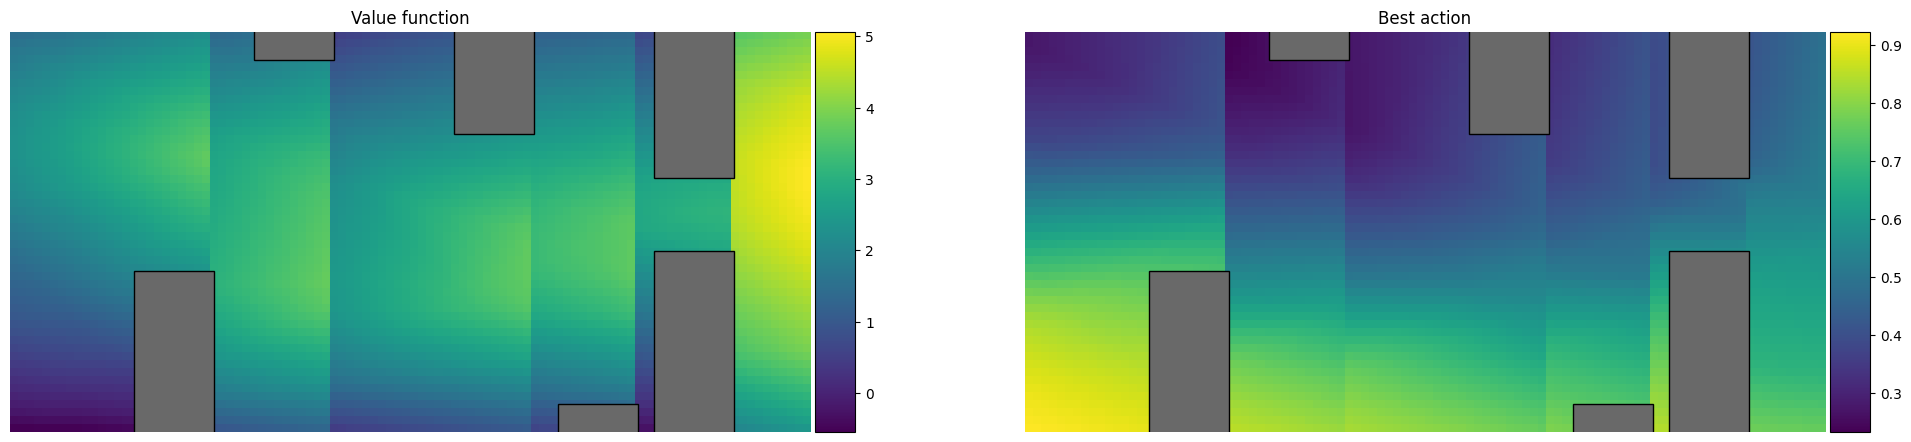

       300        |       4.33       |                  35.6                  |                 169.9                  
Saving best model at best_model.pkl


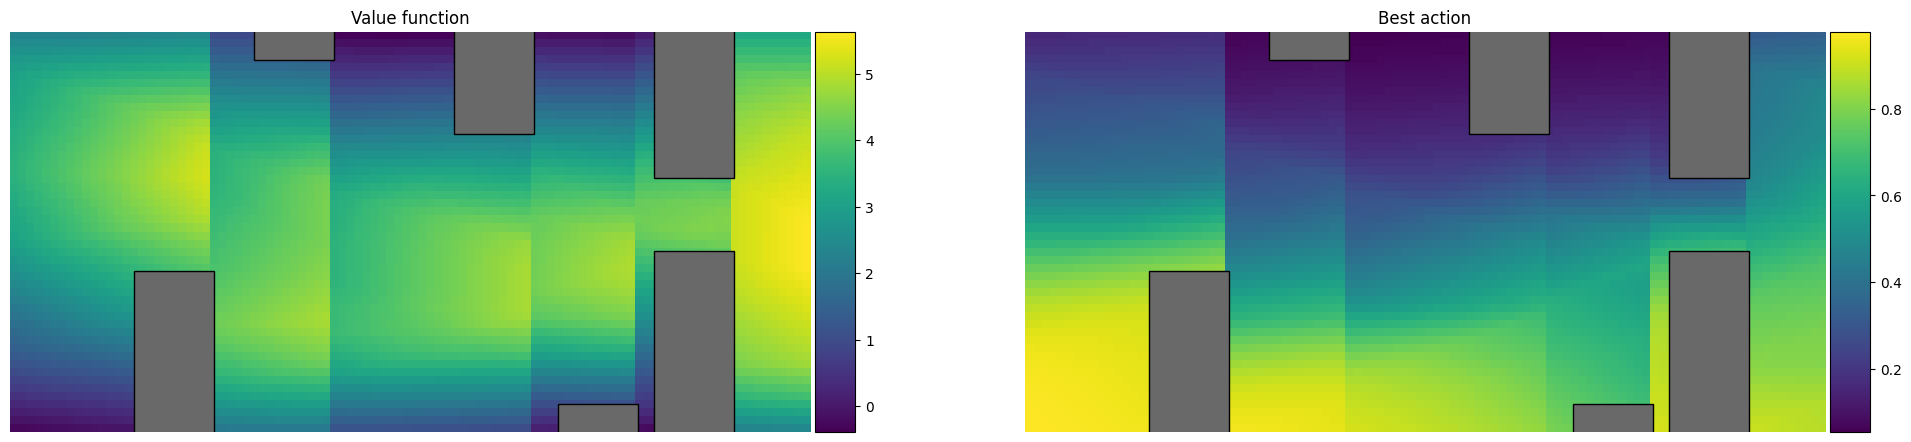

       400        |       6.49       |                  38.2                  |                 190.1                  
Saving best model at best_model.pkl


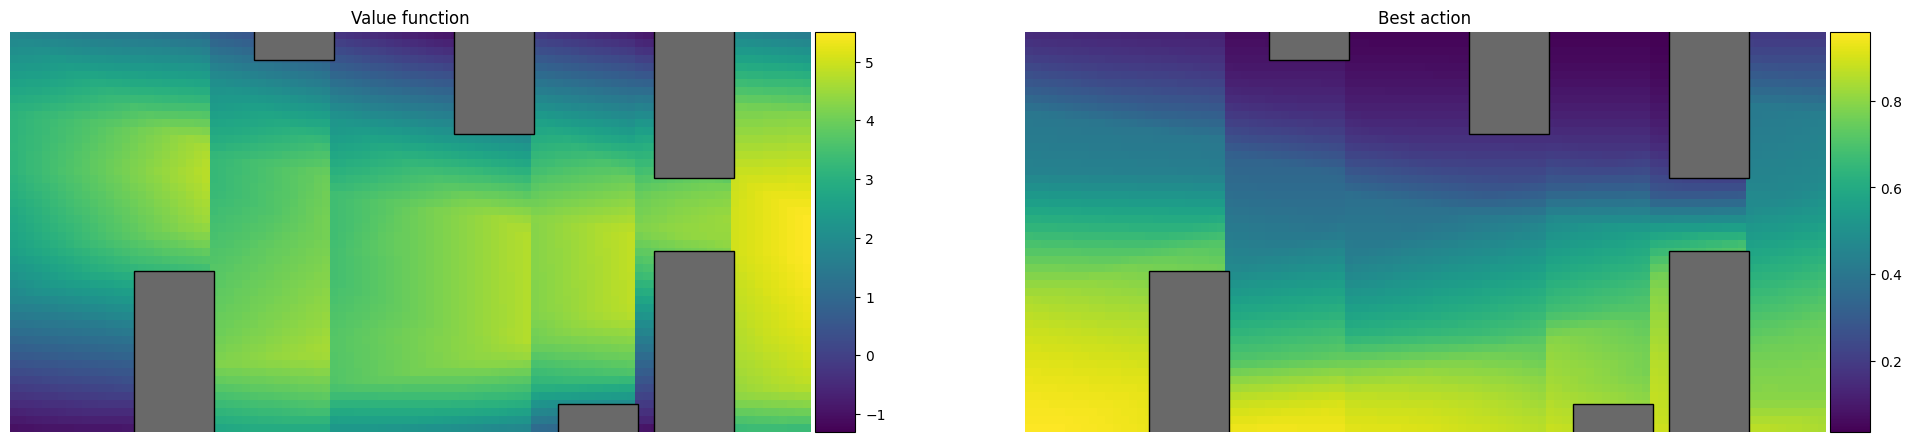

In [22]:
num_episodes = 4000
num_eval_episodes = 10
eval_every_N = 100
max_steps = 300

deep_agent = DeepAgent(
    env,
    gamma=0.95,
    eps=0.2,
    learning_rate=1e-3,
    buffer_capacity=5000,
    min_buffer_capacity=64,
    batch_size=64,
    target_ema=0.9,
    seed=42,
)


episodes, eval_rewards, eval_n_steps = train_agent(
    deep_agent,
    env,
    num_episodes=num_episodes,
    num_eval_episodes=num_eval_episodes,
    eval_every_N=eval_every_N,
    max_steps=max_steps,
    verbose=2,
)


Without rendering now, let's see the average reward we can get over 100 episodes with this agent.

In [247]:
run_dqn_episode(
    deep_agent, env, evaluation=True, max_steps=2000, renderer=renderer, time_between_frame=0.1
)


🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　

(57, 243)

In [7]:
# Flappy bird environment
env = FlappyBird(
    gravity=0.05,
    force_push=0.1,
    vx=0.05,
    prob_new_bar=0.3,
    max_height_bar=0.6,
)

# Our agent
agent = StableAgent()

N_EPISODES = 100

reward = 0
for _ in range(N_EPISODES):
    reward += run_episode(env, agent, max_steps=1000, renderer=None)

reward /= N_EPISODES

print(f"Average reward over {N_EPISODES} episodes: {reward}")


Average reward over 100 episodes: 2.51


In [196]:
run_dqn_episode(
    deep_agent,
    env,
    evaluation=True,
    max_steps=1000,
    renderer=renderer,
    time_between_frame=0.1,
)


　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🐤　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　🟩🟩🟩🟩🟩🟩🟩　　　　　　　　　　　　　　　　　　　　　
　　　　　　　　　　　　　　　　　　　　　　　　

(-1, 12)

An now, you need to do much better.

## Let's get to work !

Design and train an agent that performs the best possible score on Flappy bird. You can use any method learned in this class. Here are the constraints:
- if you chose a Deep learning algorithm, you must use jax and Haiku. Pytorch is not allowed for this project.
- your agent should converge in less than an hour. To make sure of that, we will run your code and use whatever checkpoint you have dumped in the given time.
- your agent must maximize the reward obtained over 100 episodes with a maximal number of 1000 steps per episode.

Do not forget to write **clear and commented code**, you will also be evaluated on that.

On top of that, you are asked to plot and analyse the relevant curves showing the evolution of your training loop.

In [141]:
1000 / 6


166.66666666666666

### Agent's API

Your agent should implement a method, `sample_action`, which takes two arguments as input, the observed state and wether or not it is in evaluation mode, and pick the action to perform. Appart from that, you can add any other method you want to your model.

In [ ]:
class MyAgent:
  """Your agent to beat Flappy bird."""

  def __init__(self, ...):
  # Put whatever you want here

  def sample_action(self,
                    observation: FlappyObs,
                    evaluation: bool,
                    ) -> int:
    """Pick the next action to perform

    Args:
      observation: state of the flappy bird environment.,
      evaluation: True if we are in evaluation mode, False if we are training.
    """

    # Your code here !
    ...

    return action

## Environment

You must use the following flappy bird environment from the deep_rl package.


In [ ]:
from deep_rl.project_values import PROJECT_FLAPPY_BIRD_ENV


### Training loop

You can use the following training loop to train your agent. Do not hesitate to play with the different parameters or even modify the code if you think you have a better option.

In [6]:
from typing import List, Tuple
from dataclasses import dataclass
import time

# Your training loop should perform in less than 1h.
MAX_TIME_TRAINING = 3600

@dataclass
class EpisodeTrainingStatus:
  episode_number: int
  reward: float
  training_time: float

def run_episode_no_rendering(env,
                             agent,
                             evaluation: bool,
                             max_steps: int,
                             ) -> float:
  """Runs a single episode.

  Args:
    env: environment to consider.
    agent: agent to run.
    evaluation: if False, will train the agent.
    max_steps: number of steps after wich the evaluation should be stoppped
      no matter what.
  Returns:
    The total reward accumulated over the episode.
	"""

	observation = env.reset()
	tot_reward = 0

	for _ in range(max_steps):

		action = agent.sample_action(observation, evaluation)
		observation, reward, end_game = env.step(action)
		tot_reward += reward

		if end_game:
			break

	return tot_reward

def train_agent(env,
                agent,
                num_episodes: int,
                num_eval_episodes: int,
                eval_every_N: int,
                max_steps_episode: int,
                max_time_training: float = MAX_TIME_TRAINING,
                ) -> List[EpisodeTrainingStatus]:
  """Train your agent on the given environment.

  Args:
    env: environment to consider.
    agent: agent to train.
    num_episodes: number of episode to run for training.
    eval_every_N: frequency at which the agent is evaluated.
    max_steps_episode: maximal number of step per episode.
    max_time_training: maximal duration of the training loop (in seconds).
  Returns:
    The total reward accumulated over the episode.
	"""

  all_status = []
  print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
  print("------------------------------------------------------")

  start_time = time.time()

  for episode in range(num_episodes):

    run_episode_no_rendering(env,
                             agent,
                             evaluation=False,
                             max_steps=max_steps_episode)

    if episode % eval_every_N == 0:
      reward=0
      d_time = time.time() - start_time
      for _ in range(num_eval_episodes):
        reward += run_episode(env,
                              agent,
                              evaluation=True,
                              max_steps=max_steps_episode)
      reward /= num_eval_episodes
      print(f"\t{episode}\t|\t{reward}")
      all_status.append(EpisodeTrainingStatus(episode_number=episode,
                                              reward=reward,
                                              training_time=d_time))

      if d_time > max_time_training:
        break

  return all_status

### Visualisation

You can use the following code to visualize a single run made by your agent. This can help you for debugging.

In [ ]:
from IPython.display import clear_output
from deep_rl.project_values import PROJECT_FLAPPY_BIRD_ENV
from deep_rl.terminal_renderer import BashRenderer
from deep_rl.episode_runner import run_episode

# Your agent
agent = ...

# We are going to render the environment !
ROWS = 30
COLS = 60
renderer = BashRenderer(ROWS, COLS, clear_fn=lambda: clear_output(wait=True))


# We run a single episode, with rendering, over a maximum of 1000 steps
run_episode(
    PROJECT_FLAPPY_BIRD_ENV,
    agent,
    max_steps=1000,
    renderer=renderer,
    time_between_frame=0.1,
)
